<span style="float: left;padding: 1.3em">![logo](https://github.com/caitlin-rose/odw/blob/main/Tutorials/logo.png?raw=1)</span>

# Gravitational Wave Open Data Workshop

## Tutorial 2.1 PyCBC Tutorial, An introduction to matched-filtering

We will be using the [PyCBC](https://pycbc.org) library, which is used to study gravitational-wave data, find astrophysical sources due to compact binary mergers, and study their parameters. These are some of the same tools that the LIGO and Virgo collaborations use to find gravitational waves in LIGO/Virgo data

In this tutorial we will walk through how to find a specific signal in LIGO data. We present matched filtering as a cross-correlation, in both the time domain and the frequency domain. In the next tutorial (2.2), we use the method as encoded in PyCBC, which is optimal in the case of Gaussian noise and a known signal model. In reality our noise is not entirely Gaussian, and in practice we use a variety of techniques to separate signals from noise in addition to the use of the matched filter.

View this tutorial on [Google Colaboratory](https://colab.research.google.com/github/gw-odw/odw/blob/main/Tutorials/Day_2/Tuto_2.1_Matched_filtering_introduction.ipynb) or launch [mybinder](https://mybinder.org/v2/gh/gw-odw/odw/HEAD).

See [additional examples](https://pycbc.org/pycbc/latest/html/#library-examples-and-interactive-tutorials) and [documentation](https://pycbc.org/pycbc/latest/html/index.html).

In [1]:
# Those 2 lines are just to avoid some harmless warnings when importing packages
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

## Installation (execute only if running on a cloud platform, like Google Colab, or if you haven't done the installation already!)

> ⚠️ **Warning**: restart the runtime after running the cell below.
>
> To do so, click "Runtime" in the menu and choose "Restart and run all".

In [2]:
# -- Use the following for Google Colab
! pip install -q 'lalsuite==7.25' 'PyCBC==2.4.1'

## Matched-filtering: Finding well modelled signals in Gaussian noise

Matched filtering can be shown to be the optimal method for "detecting" _known_ signals in _Gaussian_ noise. We'll explore those two assumptions a little later, but for now let's demonstrate how this works.

Let's assume you have a stretch of noise, white noise to start:

In [3]:
import numpy
# The first import of matplotlib can take some time (especially on cloud platforms). This is normal.
import matplotlib.pyplot as plt

# specify the sample rate.
# LIGO raw data is sampled at 16384 Hz (=2^14 samples/second).
# It captures signal frequency content up to f_Nyquist = 8192 Hz.
# Here, we will make the computation faster by sampling at a lower rate.
sample_rate = 1024 # samples per second
data_length = 1024 # seconds

# Generate a long stretch of white noise: the data series and the time series.
data = numpy.random.normal(size=[sample_rate * data_length])
times = numpy.arange(len(data)) / float(sample_rate)

And then let's add a gravitational wave signal to some random part of this data.

In [4]:
from pycbc.waveform import get_td_waveform

# the "approximant" (jargon for parameterized waveform family).
# IMRPhenomD(a phenomenological Inspiral–Merger–Ringdown wafeform model) is defined in the frequency domain, but we'll get it in the time domain (td).
# It runs fast, but it doesn't include effects such as non-aligned component spin, or higher order modes.
apx = 'IMRPhenomD'

Reference for [IMRPhenomD](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.93.044006). You can specify [many parameters](https://pycbc.org/pycbc/latest/html/pycbc.waveform.html?highlight=get_td_waveform#pycbc.waveform.waveform.get_td_waveform), but here, we'll use defaults for everything except the masses.

`get_td_waveform` returns both $h_+$ and $h_{\times}$, but we'll only use $h_+$ for now.

In [5]:
hp1, _ = get_td_waveform(approximant=apx,
                         mass1=10,
                         mass2=10,
                         delta_t=1.0/sample_rate,
                         f_lower=25)

The amplitude of gravitational-wave signals is normally of order $10^{-20}$. To demonstrate our method on white noise with amplitude $O(1)$ we normalize our signal so the cross-correlation of the signal with itself will give a value of 1.

In this case we can interpret the cross-correlation of the signal with white noise as a signal-to-noise ratio.

In [6]:
hp1 = hp1 / max(numpy.correlate(hp1, hp1, mode='full'))**0.5

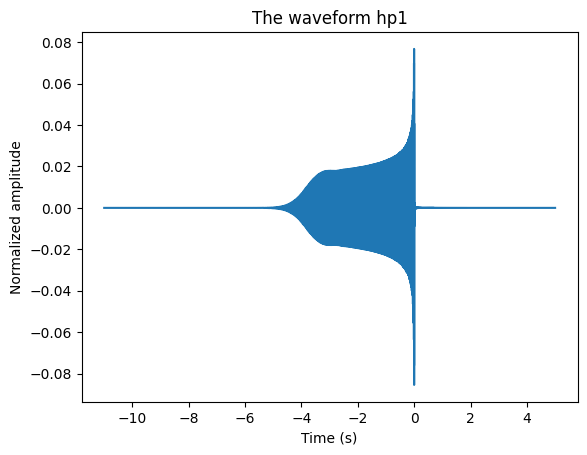

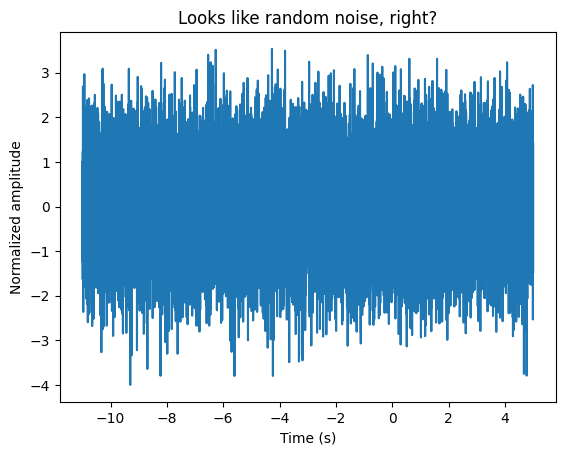

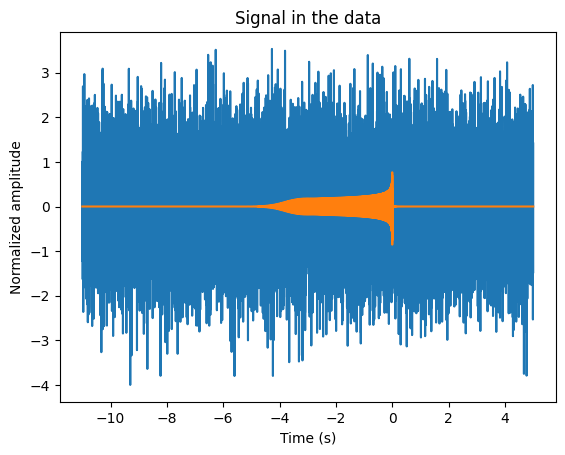

In [7]:
# note that in this figure, the waveform amplitude is of order 1.
# The duration (for frequency above f_lower=25 Hz) is only 3 or 4 seconds long.
# The waveform is "tapered": slowly ramped up from zero to full strength, over the first second or so.
# It is zero-padded at earlier times.
plt.figure()
plt.title("The waveform hp1")
plt.plot(hp1.sample_times, hp1)
plt.xlabel('Time (s)')
plt.ylabel('Normalized amplitude')

# Shift the waveform to start at a random time in the Gaussian noise data.
waveform_start = numpy.random.randint(0, len(data) - len(hp1))
data[waveform_start:waveform_start+len(hp1)] += 10 * hp1.numpy()

plt.figure()
plt.title("Looks like random noise, right?")
plt.plot(hp1.sample_times, data[waveform_start:waveform_start+len(hp1)])
plt.xlabel('Time (s)')
plt.ylabel('Normalized amplitude')

plt.figure()
plt.title("Signal in the data")
plt.plot(hp1.sample_times, data[waveform_start:waveform_start+len(hp1)])
plt.plot(hp1.sample_times, 10 * hp1)
plt.xlabel('Time (s)')
plt.ylabel('Normalized amplitude')
plt.show()

To search for this signal we can cross-correlate the signal with the entire dataset -> Not in any way optimized at this point, just showing the method.

We will do the cross-correlation in the time domain, once for each time step. It runs slowly...

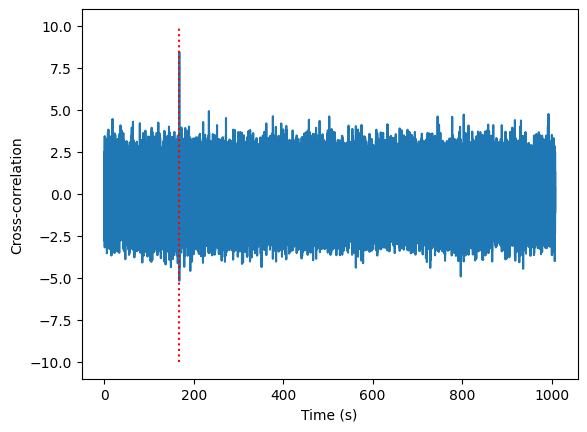

In [8]:
cross_correlation = numpy.zeros([len(data)-len(hp1)])
hp1_numpy = hp1.numpy()
for i in range(len(data) - len(hp1_numpy)):
    cross_correlation[i] = (hp1_numpy * data[i:i+len(hp1_numpy)]).sum()

# plot the cross-correlated data vs time. Superimpose the location of the end of the signal;
# this is where we should find a peak in the cross-correlation.
plt.figure()
times = numpy.arange(len(data) - len(hp1_numpy)) / float(sample_rate)
plt.plot(times, cross_correlation)
plt.plot([waveform_start/float(sample_rate), waveform_start/float(sample_rate)], [-10,10],'r:')
plt.xlabel('Time (s)')
plt.ylabel('Cross-correlation')
plt.show()

### Detection in Colored Noise

Here you can see that the largest spike from the cross-correlation comes at the time of the signal. We only really need one more ingredient to describe matched-filtering: "Colored" noise (Gaussian noise but with a frequency-dependent variance; white noise has frequency-independent variance).

Let's repeat the process, but generate a stretch of data colored with LIGO's zero-detuned--high-power noise curve. We'll use the PyCBC library to do this.

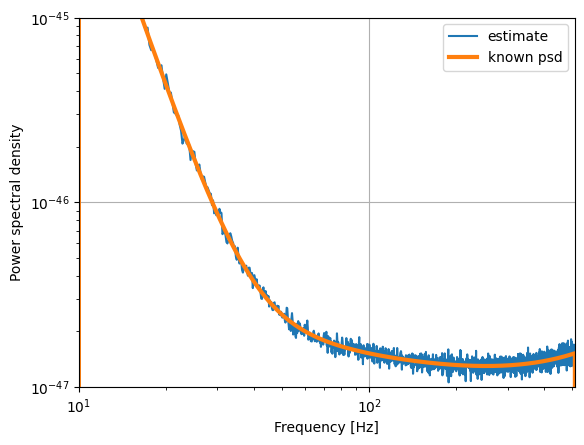

In [9]:
# https://pycbc.org/pycbc/latest/html/noise.html
import pycbc.noise
import pycbc.psd

# The color of the noise matches a PSD which you provide:
# Generate a PSD matching Advanced LIGO's zero-detuned--high-power noise curve
flow = 10.0
delta_f = 1.0 / 128
flen = int(sample_rate / (2 * delta_f)) + 1
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

# Generate colored noise
delta_t = 1.0 / sample_rate
ts = pycbc.noise.noise_from_psd(data_length*sample_rate, delta_t, psd, seed=127)

# Estimate the amplitude spectral density (ASD = sqrt(PSD)) for the noisy data
# using the "welch" method. We'll choose 4 seconds PSD samples that are overlapped 50%
seg_len = int(4 / delta_t)
seg_stride = int(seg_len / 2)
estimated_psd = pycbc.psd.welch(ts,seg_len=seg_len,seg_stride=seg_stride)

# plot it:
plt.loglog(estimated_psd.sample_frequencies, estimated_psd, label='estimate')
plt.loglog(psd.sample_frequencies, psd, linewidth=3, label='known psd')
plt.xlim(xmin=flow, xmax=512)
plt.ylim(1e-47, 1e-45)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power spectral density')
plt.legend()
plt.grid()
plt.show()

# add the signal, this time, with a "typical" amplitude.
ts[waveform_start:waveform_start+len(hp1)] += hp1.numpy() * 1E-20

Then all we need to do is to "whiten" both the data, and the template waveform. This can be done, in the frequency domain, by dividing by the PSD. This *can* be done in the time domain as well, but it's more intuitive in the frequency domain

In [10]:
# Generate a PSD for whitening the data
from pycbc.types import TimeSeries

# The PSD, sampled properly for the noisy data
flow = 10.0
delta_f = 1.0 / data_length
flen = int(sample_rate / (2 * delta_f)) + 1
psd_td = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, 0)

# The PSD, sampled properly for the signal
delta_f = sample_rate / float(len(hp1))
flen = int(sample_rate / (2 * delta_f)) + 1
psd_hp1 = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, 0)

# The 0th and Nth values are zero. Set them to a nearby value to avoid dividing by zero.
psd_td[0] = psd_td[1]
psd_td[len(psd_td) - 1] = psd_td[len(psd_td) - 2]
# Same, for the PSD sampled for the signal
psd_hp1[0] = psd_hp1[1]
psd_hp1[len(psd_hp1) - 1] = psd_hp1[len(psd_hp1) - 2]

# convert both noisy data and the signal to frequency domain,
# and divide each by ASD=PSD**0.5, then convert back to time domain.
# This "whitens" the data and the signal template.
# Multiplying the signal template by 1E-21 puts it into realistic units of strain.
data_whitened = (ts.to_frequencyseries() / psd_td**0.5).to_timeseries()
hp1_whitened = (hp1.to_frequencyseries() / psd_hp1**0.5).to_timeseries() * 1E-21

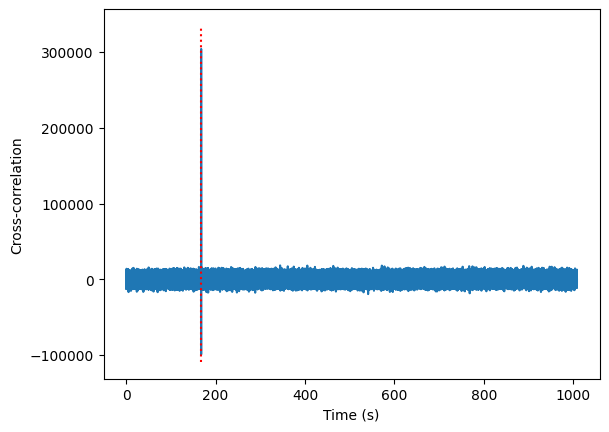

In [11]:
# Now let's re-do the correlation, in the time domain, but with whitened data and template.
cross_correlation = numpy.zeros([len(data)-len(hp1)])
hp1n = hp1_whitened.numpy()
datan = data_whitened.numpy()
for i in range(len(datan) - len(hp1n)):
    cross_correlation[i] = (hp1n * datan[i:i+len(hp1n)]).sum()

# plot the cross-correlation in the time domain. Superimpose the location of the end of the signal.
# Note how much bigger the cross-correlation peak is, relative to the noise level,
# compared with the unwhitened version of the same quantity. SNR is much higher!
plt.figure()
times = numpy.arange(len(datan) - len(hp1n)) / float(sample_rate)
plt.plot(times, cross_correlation)
plt.plot([waveform_start/float(sample_rate), waveform_start/float(sample_rate)],
           [(min(cross_correlation))*1.1,(max(cross_correlation))*1.1],'r:')
plt.xlabel('Time (s)')
plt.ylabel('Cross-correlation')
plt.show()

# Challenge!

* Histogram the whitened time series. Ignoring the outliers associated with the signal, is it a Gaussian? What is the mean and standard deviation? (We have not been careful in normalizing the whitened data properly).
* Histogram the above cross-correlation time series. Ignoring the outliers associated with the signal, is it a Gaussian? What is the mean and standard deviation?
* (Optional) Find the location of the peak. (Note that here, it can be positive or negative), and the value of the SNR of the signal (which is the absolute value of the peak value, divided by the standard deviation of the cross-correlation time series).

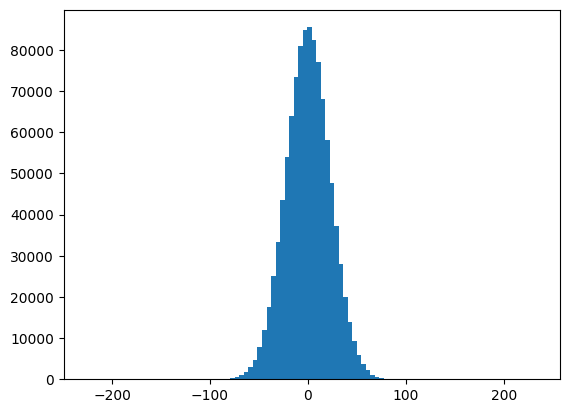

In [12]:
plt.hist(datan,bins=100)
plt.show()

Yes it does look Gaussian.

In [13]:
counts, bins = numpy.histogram(datan,bins=100)
mids = (bins[:-1] + bins[1:]) / 2
mean = numpy.average(mids, weights=counts)
print(mean)
variance = numpy.average((mids - mean)**2, weights=counts)
std_dev = numpy.sqrt(variance)
print(std_dev)

0.0033532693920272708
22.51705399412714


For cross-correlation:

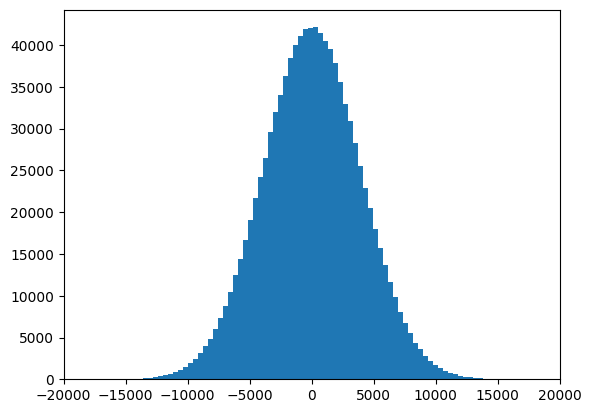

In [14]:
plt.hist(cross_correlation,bins=1000)
plt.xlim(-20000,20000)
plt.show()

Yeah this also looks Gaussian.

In [15]:
counts, bins = numpy.histogram(cross_correlation,bins=1000)
mids = (bins[:-1] + bins[1:]) / 2
mean = numpy.average(mids, weights=counts)
print(mean)
variance = numpy.average((mids - mean)**2, weights=counts)
std_dev = numpy.sqrt(variance)
print(std_dev)

-0.018935283015594447
3990.005804004645
